# Sitting Posture Detection

Group Member:
- Christoffer Edbert Karuniawan (2602082944)
- Jason Nicholas (2602133043)
- Kenzie Raditya Tirtarahardja (2602153581)
----

In this notebook, we will analyze the accuracy of our model. 

### Importing Library

We use cv2 from OpenCV and MediaPipe for our model. We also import other useful library for implementation and visualization.

In [41]:
import os
import cv2
import time
import math as m
import mediapipe as mp
import numpy as np
import seaborn as sn
import pandas as pd

Initializing mediapipe selfie implementation class

In [42]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

### Angle Calculator Function

This function is very important to calculate the angle of the body posture, which is the fundamental for determining good or bad posture.

<img src="ilustration/angle_ilustration.jpg" align="middle" width="500" height="600">

We can see these points as vectors and try to compute $\theta$.

$$
\theta = \arccos (\frac{\vec{P_{12}}.\vec{P_{13}}}{|\vec{P_{12}}|.|\vec{P_{13}}|})
$$

Note that $P_3$ can be any point, as long as it is verticaly aligned (have the same x-coordinate) with $P_1$. For simplicity, we will assume that $P_3$ has a value y of $0$.
Hence,

$$
\theta = \arccos (\frac{y_1^2 - y_1.y_2}{y_1\sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}})
$$

In [43]:
def angle(x1, y1, x2, y2):
    a = (y2 - y1) * (-y1)
    b = (m.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2) * y1)
    if b != 0:
        theta = m.acos(a / b)
        degree = int(180 / m.pi) * theta
    else:
        degree = 0
    return degree

### Posture Checker Function

We pass the directory and filename of the test image. We then determine whether the posture is good or bad by calculating the neck inclination (by computing the angle between left shoulder and left ear) and torso inclination (by computing the angle between left hip and left shoulder).

In [44]:
def checkPosture(dir, filename):
    image = cv2.imread(dir+"/"+filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h, w = image.shape[:2]

    keypoints = pose.process(image)
    
    lm = keypoints.pose_landmarks
    lmPose = mp_pose.PoseLandmark

    if lm == None:
        return -1
    
    # Acquire landmark coordinates
    # Left Shoulder
    left_shoulder_x = int(lm.landmark[lmPose.LEFT_SHOULDER].x * w)
    left_shoulder_y = int(lm.landmark[lmPose.LEFT_SHOULDER].y * w)
    # Left Ear
    left_ear_x = int(lm.landmark[lmPose.LEFT_EAR].x * w)
    left_ear_y = int(lm.landmark[lmPose.LEFT_EAR].y * w)
    # Left hip
    left_hip_x = int(lm.landmark[lmPose.LEFT_HIP].x * w)
    left_hip_y = int(lm.landmark[lmPose.LEFT_HIP].y * w)

    # Calculate angles
    neck_inclination = angle(left_shoulder_x, left_shoulder_y, left_ear_x, left_ear_y)
    torso_inclination = angle(left_hip_x, left_hip_y, left_shoulder_x, left_shoulder_y)

    if neck_inclination < 25 and torso_inclination < 8:
        return 1
    return 0

### Testing the Dataset

There are 4 directory, 2 of them contain bad posture pictures and 2 of them contain good posture pictures. We will test our model for all of them, and create a confusion matrix.

In [45]:
# Directory for all data set
bad_directory1 = "test_dataset/data/bad/1"
bad_directory2 = "test_dataset/data/bad/2"
good_directory1 = "test_dataset/data/good/1"
good_directory2 = "test_dataset/data/good/2"

# Declare confusion matrix (0: bad, 1: good)
conf_mat = np.zeros([2, 2], dtype=int)

miss_scan = 0

# Test first bad posture folder
for filename in os.listdir(bad_directory1):
    if not filename.endswith('.jpg'):
        continue
    
    if checkPosture(bad_directory1, filename) == 0:
        conf_mat[0][0] += 1
    elif checkPosture(bad_directory1, filename) == 1:
        conf_mat[0][1] += 1
    else:
        miss_scan += 1

# Test second bad posture folder
for filename in os.listdir(bad_directory2):
    if not filename.endswith('.jpg'):
        continue

    if checkPosture(bad_directory2, filename) == 0:
        conf_mat[0][0] += 1
    elif checkPosture(bad_directory2, filename) == 1:
        conf_mat[0][1] += 1
    else:
        miss_scan += 1

# Test first good posture folder
for filename in os.listdir(good_directory1):
    if not filename.endswith('.jpg'):
        continue

    if checkPosture(good_directory1, filename) == 0:
        conf_mat[1][0] += 1
    elif checkPosture(good_directory1, filename) == 1:
        conf_mat[1][1] += 1
    else:
        miss_scan += 1

# Test second good posture folder
for filename in os.listdir(good_directory2):
    if not filename.endswith('.jpg'):

        continue
    if checkPosture(good_directory2, filename) == 0:
        conf_mat[1][0] += 1
    elif checkPosture(good_directory2, filename) == 1:
        conf_mat[1][1] += 1
    else:
        miss_scan += 1

### Plotting the Confusion Matrix

Plotting the confusion matrix using the seaborn library

[Text(0.5, 1.0, 'Confusion Matrix')]

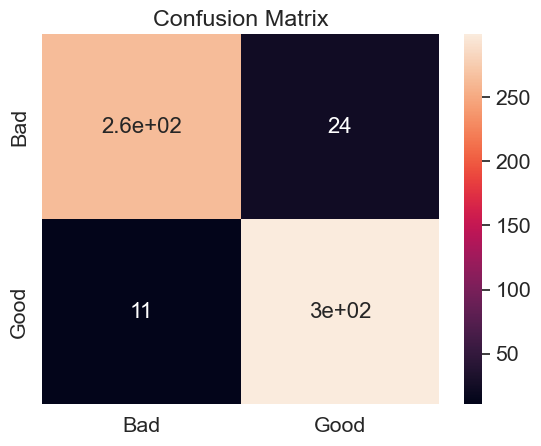

In [46]:
df_con = pd.DataFrame(conf_mat, range(2), range(2))

df_con = df_con.set_axis(["Bad", "Good"], axis="columns")
df_con = df_con.set_axis(["Bad", "Good"], axis="index")

sn.set(font_scale=1.4)
sn.heatmap(df_con, annot=True, annot_kws={"size": 16}).set(title="Confusion Matrix")

### Computing Accuracy

We can compute the accuracy our model from our confusion matrix with the formula

$$
TP+TN \over TP+TN+FP+FN
$$

Note:
- $TP$: True Positive
- $TN$: True Negative
- $FP$: False Positive
- $FN$: False Negative

In [47]:
Accuracy = (conf_mat[0][0]+conf_mat[1][1])/(conf_mat[0][0]+conf_mat[0][1]+conf_mat[1][1]+conf_mat[1][0])

print(f"Accuracy for our model based on our dataset: {round(Accuracy*100, 3)}%")

Accuracy for our model based on our dataset: 94.137%
